In [82]:
import pandas as pd
import numpy as np
import math
import sys
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
pre_path = "./data/"

# Load data 


In [135]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    #print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.30770,1.33280,1.30760,1.32910,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.55000,517.85000,511.43000,517.42000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.57000,46729.73000,46210.55000,46650.01000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,3676.01000,3730.00000,3676.01000,3721.67000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
4,2022-01-01 00:00:00,0.45057,0.45797,0.45002,0.45756,3.289705e+07,2022-01-01 00:59:59,1.494042e+07,30227,1.714832e+07,7.788349e+06,0,GALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,2023-11-30 23:00:00,0.26040,0.26210,0.25980,0.26190,1.004176e+07,2023-11-30 23:59:59,2.621476e+06,7398,5.443095e+06,1.421194e+06,0,GMT
165472,2023-11-30 23:00:00,14.31900,14.41000,14.28700,14.40700,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
165473,2023-11-30 23:00:00,0.76070,0.76330,0.75760,0.76260,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
165474,2023-11-30 23:00:00,59.28400,59.30900,58.95300,59.30900,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


In [137]:
data_df = data_df.sort_values(['coin_type','open_time']).reset_index(drop=True)

# 1) Compute simple hourly return per coin:
#    r_{t} = (close_{t} / close_{t−1}) − 1
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .pct_change()           # percent change from previous timestamp (same coin)
)

# 2) (Optional) Drop the very first row per coin where return is NaN:
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)

# Prepare data (Just using BTC)

In [93]:
# For illustration, let’s pick one coin: “BTCUSDT”
COIN = "BTC"

# 1) Filter for that coin and sort
df = data_df[data_df['coin_type'] == COIN].sort_values('open_time').reset_index(drop=True)

# 2) Compute the basic “label”: direction of next‐hour return
#    Label_t = 1 if return_{t+1} > 0, else 0.  We'll need to shift.
df['return'] = df['return']  # already exists
df['label_up'] = (df['return'].shift(-1) > 0).astype(int)

In [95]:
MAX_LAG = 6
L_MOM = 24
L_VOL = 24

for lag in range(1, MAX_LAG + 1):
    df[f'lag_ret_{lag}'] = df['return'].shift(lag)

df['mom_24h'] = df['close'].pct_change(periods=L_MOM)
df['vol_24h'] = df['return'].rolling(window=L_VOL, min_periods=L_VOL).std()

# 4) Drop NaNs in features/label
feature_cols = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG + 1)] + ['mom_24h', 'vol_24h']
df_model = df.dropna(subset=feature_cols + ['label_up']).reset_index(drop=True)

# 5) Chronological split: Train/Val/Test
train_end = pd.to_datetime("2023-03-31 23:00:00")
val_end   = pd.to_datetime("2023-07-31 23:00:00")

train_mask = df_model['open_time'] <= train_end
val_mask   = (df_model['open_time'] > train_end) & (df_model['open_time'] <= val_end)
test_mask  = df_model['open_time'] > val_end

X_all = df_model[feature_cols].values
y_all = df_model['label_up'].values
times = df_model['open_time']
returns_series = df_model['return']

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# Standardize features for models that require scaling (Lasso, LSTM)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

In [104]:
def compute_sharpe_from_signal(signal_series, returns_series):
    pnl = signal_series.shift(1).fillna(0) * returns_series
    avg_ret = pnl.mean()
    std_ret = pnl.std(ddof=0)
    return (avg_ret / std_ret) * np.sqrt(8760) if std_ret != 0 else np.nan, pnl, (1 + pnl.fillna(0)).cumprod()


# Training 

In [107]:
val_indices = df_model.index[val_mask]
test_indices = df_model.index[test_mask]

# Container for best models and their results
best_models = {}
model_results = {}

In [109]:

lasso_params = {'C': [0.01, 0.1, 1, 10, 100]}
best_sharpe = -np.inf
for C in lasso_params['C']:
    model = LogisticRegression(penalty='l1', solver='saga', C=C, max_iter=10000)
    model.fit(X_train_std, y_train)
    val_prob = model.predict_proba(X_val_std)[:,1]
    thr = 0.5
    sig = pd.Series(index=val_indices, data=0)
    sig[val_prob > thr] = 1
    sig[val_prob < (1 - thr)] = -1
    sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
    if sharpe_val > best_sharpe:
        best_sharpe = sharpe_val
        best_models['Lasso'] = {'model': model, 'C': C, 'threshold': thr, 'sharpe_val': sharpe_val}


In [111]:
xgb_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
best_sharpe = -np.inf
for n_est in xgb_grid['n_estimators']:
    for md in xgb_grid['max_depth']:
        for lr in xgb_grid['learning_rate']:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                  n_estimators=n_est, max_depth=md,
                                  learning_rate=lr, random_state=42, verbosity=0)
            model.fit(X_train, y_train)
            val_prob = model.predict_proba(X_val)[:,1]
            thr = 0.5
            sig = pd.Series(index=val_indices, data=0)
            sig[val_prob > thr] = 1
            sig[val_prob < (1 - thr)] = -1
            sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['XGBoost'] = {'model': model, 'n_estimators': n_est,
                                          'max_depth': md, 'learning_rate': lr,
                                          'threshold': thr, 'sharpe_val': sharpe_val}


In [113]:
cat_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
best_sharpe = -np.inf
for it in cat_grid['iterations']:
    for d in cat_grid['depth']:
        for lr in cat_grid['learning_rate']:
            model = CatBoostClassifier(iterations=it, depth=d, learning_rate=lr,
                                       verbose=False, random_state=42)
            model.fit(X_train, y_train)
            val_prob = model.predict_proba(X_val)[:,1]
            thr = 0.5
            sig = pd.Series(index=val_indices, data=0)
            sig[val_prob > thr] = 1
            sig[val_prob < (1 - thr)] = -1
            sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['CatBoost'] = {'model': model, 'iterations': it,
                                          'depth': d, 'learning_rate': lr,
                                          'threshold': thr, 'sharpe_val': sharpe_val}


In [114]:
seq_features = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG + 1)]

class LagDataset(Dataset):
    def __init__(self, df_model, mask, seq_features, label_col='label_up'):
        self.indices = df_model.index[mask]
        self.X = df_model.loc[mask, seq_features].values.astype('float32')
        self.y = df_model.loc[mask, label_col].values.astype('float32')
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        seq = self.X[idx].reshape(-1, 1)  # (seq_len, 1)
        return seq, self.y[idx]

def train_lstm_model(hidden_size, lr, epochs):
    # Prepare DataLoaders
    train_ds = LagDataset(df_model, train_mask, seq_features)
    val_ds   = LagDataset(df_model, val_mask, seq_features)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
    
    # Define model
    class LSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=16, num_layers=1):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc   = nn.Linear(hidden_size, 1)
        def forward(self, x):
            out, _ = self.lstm(x)
            h_last = out[:, -1, :]
            return torch.sigmoid(self.fc(h_last)).squeeze()
    
    model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        for seq_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(seq_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation inference
    model.eval()
    val_probs = []
    with torch.no_grad():
        for seq_batch, _ in val_loader:
            val_probs.append(model(seq_batch).numpy())
    val_probs = np.concatenate(val_probs, axis=0)
    
    thr = 0.5
    sig = pd.Series(index=val_indices, data=0)
    sig[val_probs > thr] = 1
    sig[val_probs < (1 - thr)] = -1
    sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
    return model, sharpe_val

# Hyperparameter grids for LSTM
hidden_sizes = [8, 16]
lrs = [1e-3, 1e-2]
epochs_list = [5, 10]

best_sharpe = -np.inf
for hs in hidden_sizes:
    for lr in lrs:
        for ep in epochs_list:
            model, sharpe_val = train_lstm_model(hs, lr, ep)
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['LSTM'] = {'model': model, 'hidden_size': hs,
                                       'learning_rate': lr, 'epochs': ep,
                                       'threshold': 0.5, 'sharpe_val': sharpe_val}


Test Sharpe Ratios:
Lasso: Sharpe=-0.75
XGBoost: Sharpe=-1.74
CatBoost: Sharpe=0.91
LSTM: Sharpe=2.20


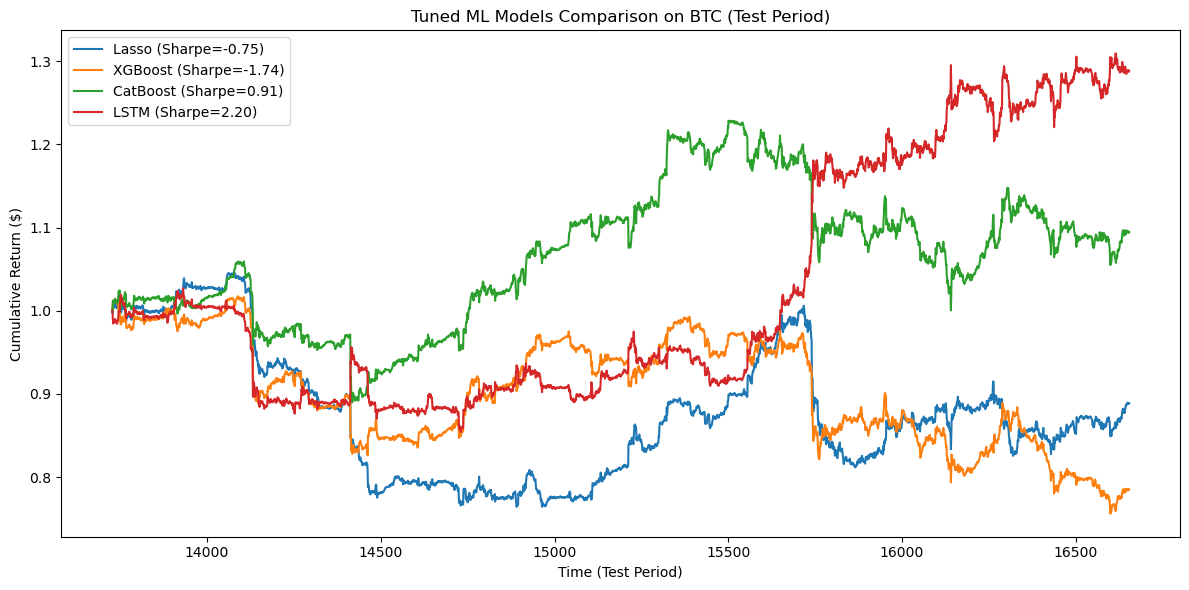


Best Hyperparameters:
Lasso: {'C': 1, 'threshold': 0.5, 'sharpe_val': 0.3612356994180074}
XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'threshold': 0.5, 'sharpe_val': 0.4049361088021661}
CatBoost: {'iterations': 200, 'depth': 3, 'learning_rate': 0.01, 'threshold': 0.5, 'sharpe_val': 0.2006895358771506}
LSTM: {'hidden_size': 8, 'learning_rate': 0.001, 'epochs': 5, 'threshold': 0.5, 'sharpe_val': 0.4064472994346425}


In [115]:
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
print("Test Sharpe Ratios:")
for name, info in best_models.items():
    if name in ['Lasso', 'XGBoost', 'CatBoost']:
        model = info['model']
        thr = info['threshold']
        # Choose correct features & scaling
        if name == 'Lasso':
            probs = model.predict_proba(X_test_std)[:, 1]
        else:
            probs = model.predict_proba(X_test)[:, 1]
        sig = pd.Series(index=test_indices, data=0)
        sig[probs > thr] = 1
        sig[probs < (1 - thr)] = -1
        sharpe_test, _, cum_pnl = compute_sharpe_from_signal(sig, returns_series[test_mask])
        print(f"{name}: Sharpe={sharpe_test:.2f}")
        model_results[name] = cum_pnl
        plt.plot(cum_pnl.index, cum_pnl.values, label=f"{name} (Sharpe={sharpe_test:.2f})", linewidth=1.5)
    elif name == 'LSTM':
        model = info['model']
        # Build test DataLoader
        test_ds = LagDataset(df_model, test_mask, seq_features)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
        model.eval()
        test_probs = []
        with torch.no_grad():
            for seq_batch, _ in test_loader:
                test_probs.append(model(seq_batch).numpy())
        test_probs = np.concatenate(test_probs, axis=0)
        thr = info['threshold']
        sig = pd.Series(index=test_indices, data=0)
        sig[test_probs > thr] = 1
        sig[test_probs < (1 - thr)] = -1
        sharpe_test, _, cum_pnl = compute_sharpe_from_signal(sig, returns_series[test_mask])
        print(f"{name}: Sharpe={sharpe_test:.2f}")
        model_results[name] = cum_pnl
        plt.plot(cum_pnl.index, cum_pnl.values, label=f"{name} (Sharpe={sharpe_test:.2f})", linewidth=1.5)

plt.xlabel("Time (Test Period)")
plt.ylabel("Cumulative Return ($)")
plt.title(f"Tuned ML Models Comparison on {COIN} (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()

# 8) Display best hyperparameters
print("\nBest Hyperparameters:")
for name, info in best_models.items():
    print(f"{name}: { {k: v for k, v in info.items() if k not in ['model']} }")


# Transformer

In [143]:
COIN = "BTC"

# 1) Filter for COIN, compute features & label
df = data_df[data_df['coin_type'] == COIN].sort_values('open_time').copy()
df['return'] = df['close'].pct_change()
df['label_up'] = (df['return'].shift(-1) > 0).astype(int)

# Lagged returns 1..6
MAX_LAG = 6
for lag in range(1, MAX_LAG+1):
    df[f'lag_ret_{lag}'] = df['return'].shift(lag)

# Already have mom_24h and vol_24h columns (compute if not):
if 'mom_24h' not in df.columns:
    df['mom_24h'] = df['close'].pct_change(periods=24)
if 'vol_24h' not in df.columns:
    df['vol_24h'] = df['return'].rolling(window=24, min_periods=24).std()

# Drop rows with NaNs
feature_cols = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG+1)] + ['mom_24h', 'vol_24h']
df = df.dropna(subset=feature_cols + ['label_up']).reset_index(drop=True)


In [147]:
# 2) Chronological split
train_end = pd.to_datetime("2023-03-31 23:00:00")
val_end   = pd.to_datetime("2023-07-31 23:00:00")

mask_train = df['open_time'] <= train_end
mask_val   = (df['open_time'] > train_end) & (df['open_time'] <= val_end)
mask_test  = df['open_time'] > val_end

df_train = df[mask_train].reset_index(drop=True)
df_val   = df[mask_val].reset_index(drop=True)
df_test  = df[mask_test].reset_index(drop=True)

# 3) Standardize features on train, apply to val/test
scaler = StandardScaler().fit(df_train[feature_cols])
df_train[feature_cols] = scaler.transform(df_train[feature_cols])
df_val[feature_cols]   = scaler.transform(df_val[feature_cols])
df_test[feature_cols]  = scaler.transform(df_test[feature_cols])

In [149]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, feature_cols, seq_len):
        self.feature_cols = feature_cols
        self.seq_len = seq_len
        self.X = df[feature_cols].values.astype('float32')
        self.y = df['label_up'].values.astype('float32')
        self.times = df['open_time'].values
        self.n = len(df)
    def __len__(self):
        return max(0, self.n - self.seq_len)
    def __getitem__(self, idx):
        seq = self.X[idx:idx+self.seq_len]
        label = self.y[idx+self.seq_len-1]
        return seq, label

# 5) Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# 6) Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        h_last = x[:, -1, :]
        return self.output_fc(h_last).squeeze()

# 7) Sharpe computation helper
def compute_sharpe_from_signal(signal, returns):
    pnl = signal.shift(1).fillna(0) * returns
    avg_ret = pnl.mean()
    std_ret = pnl.std(ddof=0)
    return (avg_ret / std_ret) * np.sqrt(8760) if std_ret != 0 else np.nan, pnl, (1 + pnl.fillna(0)).cumprod()


In [151]:
# 8) Hyperparameter grids (excluding epochs)
seq_lens        = [8, 12, 24]
d_models        = [32, 64, 128]
nheads          = {32:[2,4], 64:[4,8], 128:[8]}  # possible heads for each d_model
num_layers_list = [1, 2, 3]
dim_feedfwd     = [64, 128, 256]
dropouts        = [0.1, 0.2]
lrs             = [1e-3, 5e-4]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_sharpe = -np.inf
best_config = None
best_model = None

In [ ]:
# 9) Grid search
for seq_len in seq_lens:
    # Prepare datasets & loaders for this seq_len
    train_ds = TimeSeriesDataset(df_train, feature_cols, seq_len)
    val_ds   = TimeSeriesDataset(df_val,   feature_cols, seq_len)
    # align val times and returns
    val_returns = df_val['return'].reset_index(drop=True)[seq_len-1:]
    val_times = df_val['open_time'].reset_index(drop=True)[seq_len-1:-1]
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)

    for d_model in d_models:
        for nhead in nheads[d_model]:
            for num_layers in num_layers_list:
                for ff in dim_feedfwd:
                    for dropout in dropouts:
                        for lr in lrs:
                            # Instantiate model
                            model = TransformerClassifier(
                                input_dim=len(feature_cols),
                                d_model=d_model,
                                nhead=nhead,
                                num_layers=num_layers,
                                dim_feedforward=ff,
                                dropout=dropout
                            ).to(device)
                            criterion = nn.BCELoss()
                            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                            # Train for fixed 10 epochs
                            for epoch in range(10):
                                model.train()
                                for X_batch, y_batch in train_loader:
                                    X_batch = X_batch.to(device)
                                    y_batch = y_batch.to(device)
                                    optimizer.zero_grad()
                                    preds = model(X_batch)
                                    loss = criterion(preds, y_batch)
                                    loss.backward()
                                    optimizer.step()

                            # Validation inference
                            model.eval()
                            val_probs = []
                            with torch.no_grad():
                                for X_batch, _ in val_loader:
                                    X_batch = X_batch.to(device)
                                    preds = model(X_batch)
                                    val_probs.append(preds.cpu().numpy())
                            val_probs = np.concatenate(val_probs, axis=0)
                            # Build signal series
                            sig = pd.Series(data=0, index=val_times)
                            thr_up = 0.6
                            thr_down = 0.4
                            sig[val_probs > thr_up] = 1
                            sig[val_probs < thr_down] = -1

                            sharpe_val, _, _ = compute_sharpe_from_signal(sig, val_returns)
                            if sharpe_val > best_sharpe:
                                best_sharpe = sharpe_val
                                best_config = {
                                    'seq_len': seq_len,
                                    'd_model': d_model,
                                    'nhead': nhead,
                                    'num_layers': num_layers,
                                    'dim_feedforward': ff,
                                    'dropout': dropout,
                                    'lr': lr,
                                    'thresholds': (thr_up, thr_down),
                                    'sharpe_val': sharpe_val
                                }
                                best_model = model.state_dict()

# 10) Report best configuration
print("Best Transformer Configuration (by validation Sharpe):")
print(best_config)


In [ ]:
# 11) Evaluate best model on TEST set
# Rebuild datasets/loaders with best seq_len
seq_len = best_config['seq_len']
train_val_df = pd.concat([df_train, df_val]).reset_index(drop=True)
# Re-standardize for train+val? For simplicity, reuse previous scaler
combined_ds = TimeSeriesDataset(pd.concat([df_train, df_val]).reset_index(drop=True), feature_cols, seq_len)
test_ds = TimeSeriesDataset(df_test, feature_cols, seq_len)

combined_loader = DataLoader(combined_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Instantiate model with best hyperparameters
model_best = TransformerClassifier(
    input_dim=len(feature_cols),
    d_model=best_config['d_model'],
    nhead=best_config['nhead'],
    num_layers=best_config['num_layers'],
    dim_feedforward=best_config['dim_feedforward'],
    dropout=best_config['dropout']
).to(device)
model_best.load_state_dict(best_model)

# No retraining; directly test inference
model_best.eval()
test_probs = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model_best(X_batch)
        test_probs.append(preds.cpu().numpy())
test_probs = np.concatenate(test_probs, axis=0)

# Align test times and returns
test_times = df_test['open_time'].reset_index(drop=True)[seq_len-1:-1]
test_returns = df_test['return'].reset_index(drop=True)[seq_len-1:]

sig_test = pd.Series(data=0, index=test_times)
thr_up, thr_down = best_config['thresholds']
sig_test[test_probs > thr_up] = 1
sig_test[test_probs < thr_down] = -1

sharpe_test, pnl_test, cum_test = compute_sharpe_from_signal(sig_test, test_returns)

print(f"Transformer Test Sharpe: {sharpe_test:.2f}")

In [ ]:


# 12) Plot cumulative PnL
plt.figure(figsize=(10, 6))
plt.plot(cum_test.index, cum_test.values, label=f"Transformer (Sharpe={sharpe_test:.2f})", color='purple')
plt.xlabel("Time (Test Period)")
plt.ylabel("Cumulative Return ($)")
plt.title(f"Tuned Transformer Strategy on {COIN} (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()